In [14]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# --- CARICAMENTO ---
df = pd.read_csv("/Users/GeorgKhella/Desktop/Financial Statements.csv")

# --- PULIZIA NOMI COLONNE ---
df.columns = df.columns.str.strip().str.replace(" ", "_")

# --- SELEZIONE VARIABILI CHIAVE ---
df_extra = df[['Company','Year','Revenue','EBITDA','Net_Income']].copy()
df_extra = df_extra.sort_values(['Company','Year'])

# --- LAG BASE ---
for col in ['Revenue','EBITDA','Net_Income']:
    df_extra[f'{col}_lag1'] = df_extra.groupby('Company')[col].shift(1)
    df_extra[f'{col}_lag2'] = df_extra.groupby('Company')[col].shift(2)

# --- FEATURE ENGINEERING SOLO CON INFO FINO A t-1 ---
# crescita ricavi (t-1): (Rev_{t-1}/Rev_{t-2}) - 1
df_extra['Rev_growth_lag1'] = (df_extra['Revenue_lag1'] / df_extra['Revenue_lag2']) - 1

# margini a t-1
df_extra['EBITDA_margin_lag1'] = df_extra['EBITDA_lag1'] / df_extra['Revenue_lag1'].replace(0, np.nan)
df_extra['NI_margin_lag1']     = df_extra['Net_Income_lag1'] / df_extra['Revenue_lag1'].replace(0, np.nan)

# --- LOG TRASFORMAZIONI ---
df_extra['logRev']      = np.log1p(df_extra['Revenue'])
df_extra['logRev_lag1'] = np.log1p(df_extra['Revenue_lag1'])
df_extra['logRev_lag2'] = np.log1p(df_extra['Revenue_lag2'])

# EBITDA/NI possono essere negativi: sign*log1p(|x|)
df_extra['logEBITDA_lag1'] = np.sign(df_extra['EBITDA_lag1']) * np.log1p(np.abs(df_extra['EBITDA_lag1']))
df_extra['logNI_lag1']     = np.sign(df_extra['Net_Income_lag1']) * np.log1p(np.abs(df_extra['Net_Income_lag1']))

# --- PULIZIA RIGHE INUTILIZZABILI (lag mancanti) ---
df_extra = df_extra.dropna(subset=[
    'logRev','logRev_lag1','logRev_lag2',
    'Rev_growth_lag1','EBITDA_margin_lag1','NI_margin_lag1',
    'logEBITDA_lag1','logNI_lag1'
])

print("✅ Dataset senza leakage pronto")
print(df_extra.head())

# --- MODELLO: SOLO LAG + FE azienda (Year FE opzionale) ---
formula_forecast = (
    "logRev ~ logRev_lag1 + logRev_lag2 "
    "+ Rev_growth_lag1 + EBITDA_margin_lag1 + NI_margin_lag1 "
    "+ logEBITDA_lag1 + logNI_lag1 "
    "+ C(Company)"
    # + " + C(Year)"  # <— usa Year FE solo per validazioni in-sample; evita per anni futuri
)

# Fit su tutto il campione (per ispezione; non per validazione!)
model_all = smf.ols(formula=formula_forecast, data=df_extra)\
               .fit(cov_type="cluster", cov_kwds={"groups": df_extra["Company"]})
print(model_all.summary())

# --- FUNZIONE FORECAST SENZA LEAKAGE (ultimi 2 anni come test) ---
def panel_forecast(company, df_extra, use_year_fe=True):
    group = df_extra[df_extra["Company"] == company]
    cutoff = group["Year"].max() - 2

    df_train = df_extra[~((df_extra["Company"] == company) & (df_extra["Year"] > cutoff))].copy()
    df_test  = df_extra[(df_extra["Company"] == company) & (df_extra["Year"] > cutoff)].copy()

    # Allinea categorie per Company/Year
    df_train["Company"] = pd.Categorical(df_train["Company"], categories=sorted(df_extra["Company"].unique()))
    df_test["Company"]  = pd.Categorical(df_test["Company"],  categories=sorted(df_extra["Company"].unique()))
    if use_year_fe:
        years_all = sorted(df_extra["Year"].unique())
        df_train["Year"] = pd.Categorical(df_train["Year"], categories=years_all)
        df_test["Year"]  = pd.Categorical(df_test["Year"],  categories=years_all)

    formula = formula_forecast if not use_year_fe else (formula_forecast + " + C(Year)")
    model = smf.ols(formula=formula, data=df_train)\
               .fit(cov_type="cluster", cov_kwds={"groups": df_train["Company"]})

    preds_log = model.predict(df_test)
    preds_rev = np.expm1(preds_log)

    # Plot
    plt.figure(figsize=(8,5))
    plt.plot(group["Year"], group["Revenue"], marker="o", label="Storico")
    plt.plot(df_test["Year"], preds_rev, marker="o", linestyle="--", label="Forecast ultimi 2 anni")
    plt.title(f"{company} – Panel FE (solo lag)")
    plt.xlabel("Anno"); plt.ylabel("Revenue"); plt.grid(True); plt.legend(); plt.show()

    return pd.DataFrame({
        "Year": df_test["Year"].values,
        "Reale": df_test["Revenue"].values,
        "Previsto": preds_rev
    })

# --- METRICHE ---
def mae(y_true, y_pred):  return np.mean(np.abs(y_true - y_pred))
def mape(y_true, y_pred): return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def validate_models(df_extra, exclude=[]):
    rows = []
    for comp in df_extra["Company"].unique():
        if comp in exclude: continue
        g = df_extra[df_extra["Company"] == comp]
        if g["Year"].nunique() < 4:  # serve spazio per lag + test
            continue

        try:
            res = panel_forecast(comp, df_extra, use_year_fe=True)  # in-sample years
        except Exception as e:
            print(f"❌ {comp}: {e}")
            continue

        y_true = res["Reale"].values
        y_pred = res["Previsto"].values
        # benchmark naive: Revenue_{t-1} sugli stessi anni del test
        y_naive = df_extra.loc[
            (df_extra["Company"] == comp) & (df_extra["Year"].isin(res["Year"])),
            "Revenue_lag1"
        ].values

        rows.append({
            "Company": comp,
            "MAE_model": mae(y_true, y_pred),
            "MAPE_model": mape(y_true, y_pred),
            "MAE_naive": mae(y_true, y_naive),
            "MAPE_naive": mape(y_true, y_naive)
        })
    return pd.DataFrame(rows)

# --- Leave-One-Year-Out CV (senza leakage) ---
def leave_one_year_out_cv(df_extra, exclude=[]):
    out = []
    years = sorted(df_extra["Year"].unique())
    for y in years:
        df_train = df_extra[df_extra["Year"] != y].copy()
        df_test  = df_extra[df_extra["Year"] == y].copy()

        # categorie
        df_train["Company"] = pd.Categorical(df_train["Company"], categories=sorted(df_extra["Company"].unique()))
        df_test["Company"]  = pd.Categorical(df_test["Company"],  categories=sorted(df_extra["Company"].unique()))
        df_train["Year"] = pd.Categorical(df_train["Year"], categories=years)
        df_test["Year"]  = pd.Categorical(df_test["Year"],  categories=years)

        model = smf.ols(formula=(formula_forecast + " + C(Year)"),
                        data=df_train)\
                   .fit(cov_type="cluster", cov_kwds={"groups": df_train["Company"]})

        preds_log = model.predict(df_test)
        y_pred = np.expm1(preds_log)
        y_true = df_test["Revenue"].values
        y_naiv = df_test["Revenue_lag1"].values

        out.append({
            "Year": y,
            "MAE_model": mae(y_true, y_pred),
            "MAPE_model": mape(y_true, y_pred),
            "MAE_naive": mae(y_true, y_naiv),
            "MAPE_naive": mape(y_true, y_naiv)
        })
    return pd.DataFrame(out)


✅ Dataset senza leakage pronto
   Company  Year   Revenue   EBITDA  Net_Income  Revenue_lag1  Revenue_lag2  \
11    AAPL  2011  108249.0  35604.0     25922.0       65225.0       42905.0   
10    AAPL  2012  156508.0  58518.0     41733.0      108249.0       65225.0   
9     AAPL  2013  170910.0  55756.0     37037.0      156508.0      108249.0   
8     AAPL  2014  182795.0  60449.0     39510.0      170910.0      156508.0   
7     AAPL  2015  233715.0  82487.0     53394.0      182795.0      170910.0   

    EBITDA_lag1  EBITDA_lag2  Net_Income_lag1  Net_Income_lag2  \
11      19412.0      12474.0          14013.0           8235.0   
10      35604.0      19412.0          25922.0          14013.0   
9       58518.0      35604.0          41733.0          25922.0   
8       55756.0      58518.0          37037.0          41733.0   
7       60449.0      55756.0          39510.0          37037.0   

    Rev_growth_lag1  EBITDA_margin_lag1  NI_margin_lag1     logRev  \
11         0.520219        

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 18, but rank is 7
  warnings.warn('covariance of constraints does not have full '



=== AAPL ===


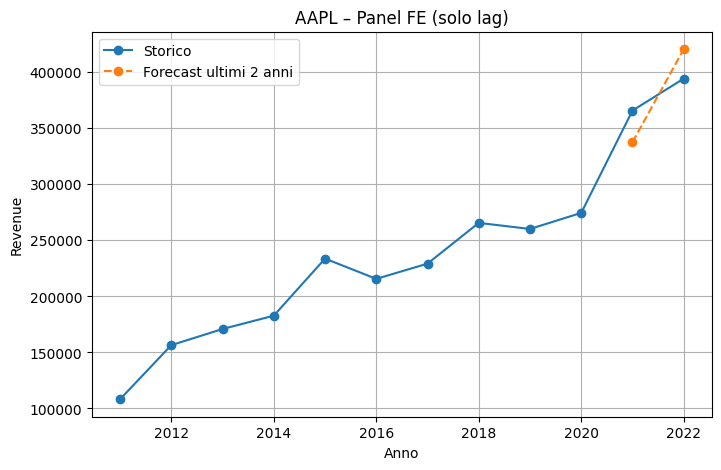


=== AIG ===


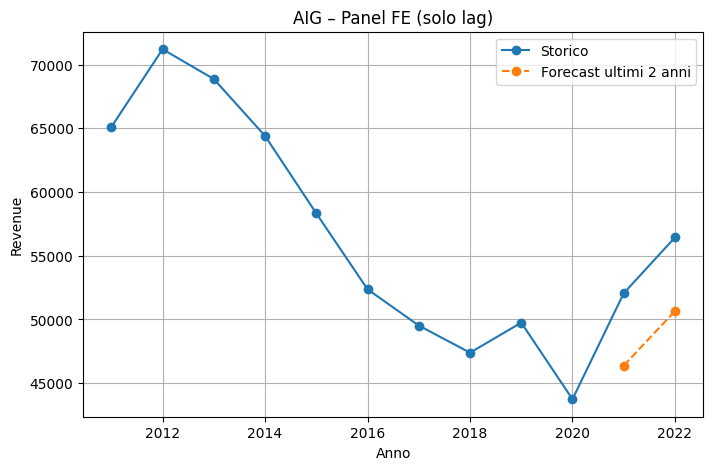


=== AMZN ===


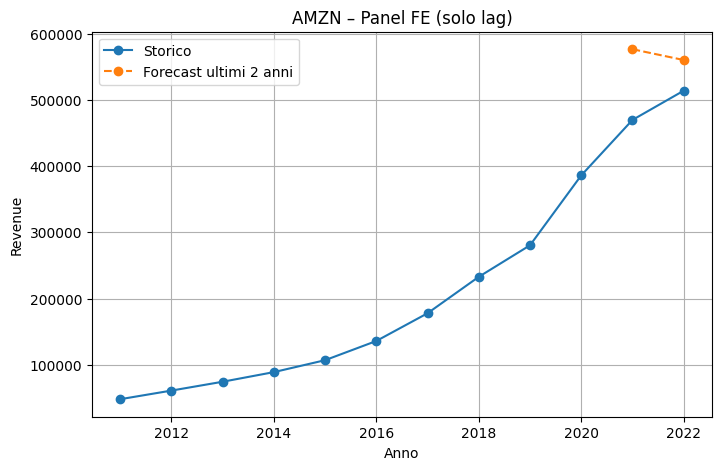


=== BCS ===


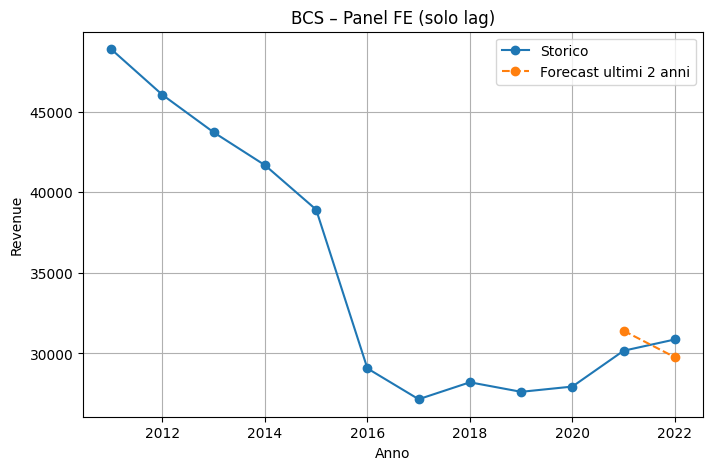


=== GOOG ===


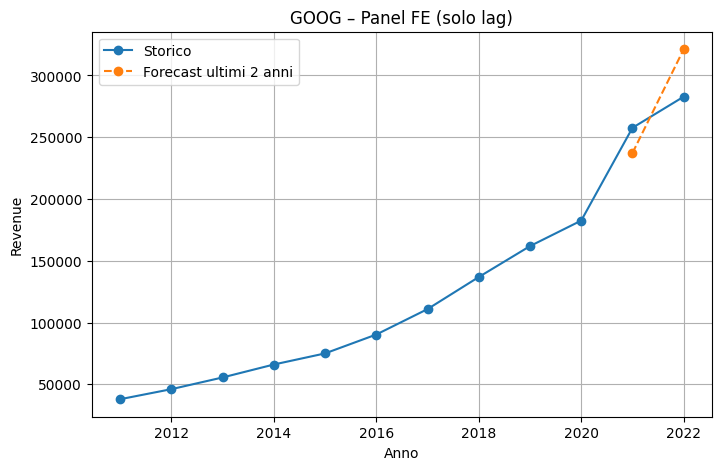


=== INTC ===


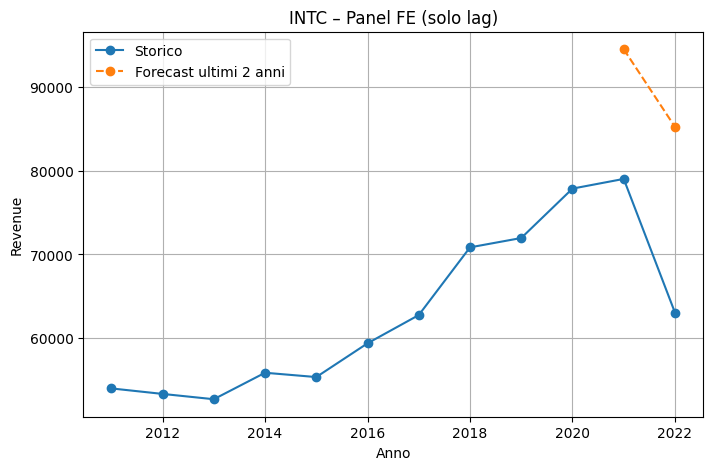


=== MCD ===


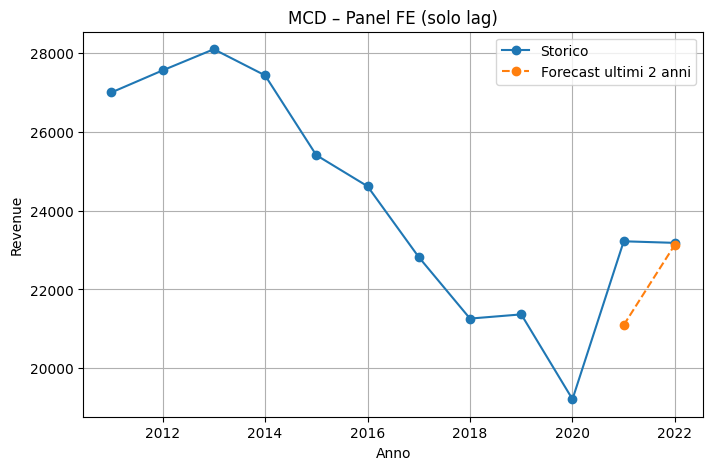


=== MSFT ===


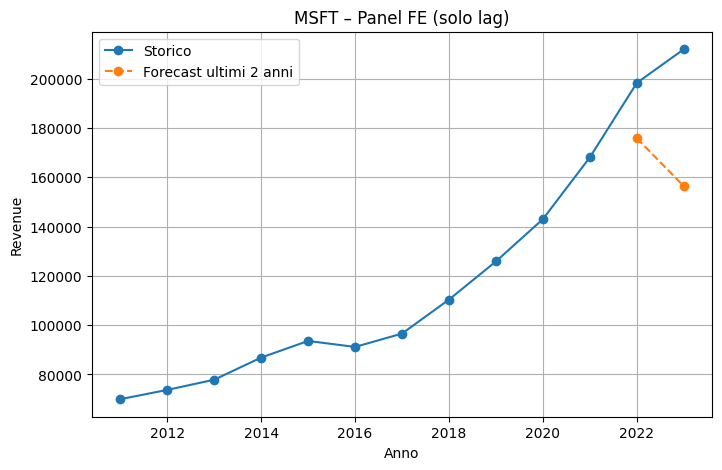


=== NVDA ===


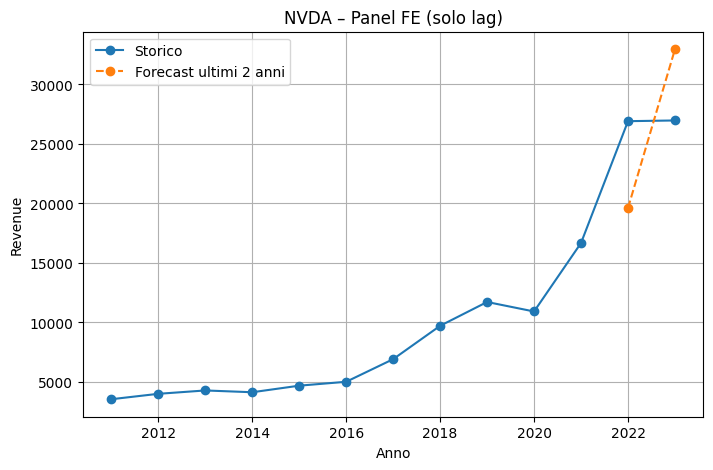


=== PCG ===


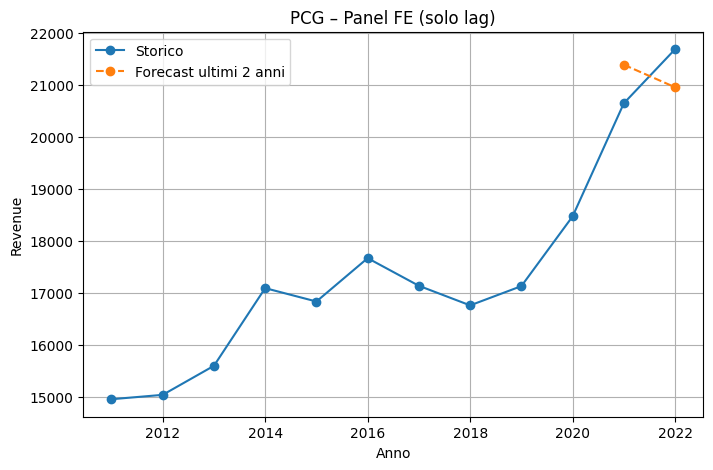


=== PYPL ===


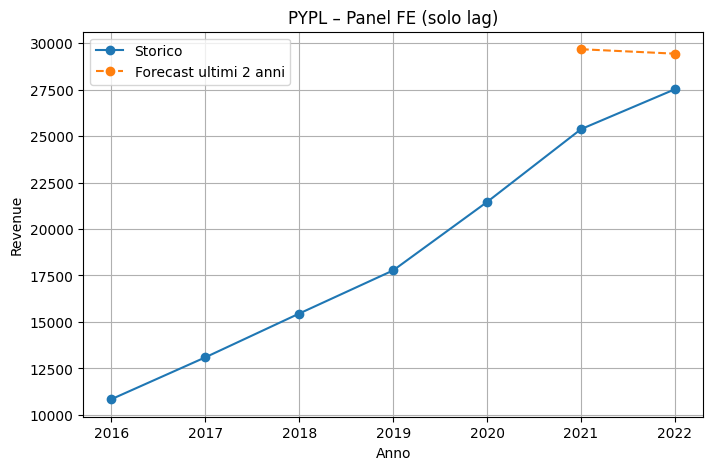


=== SHLDQ ===


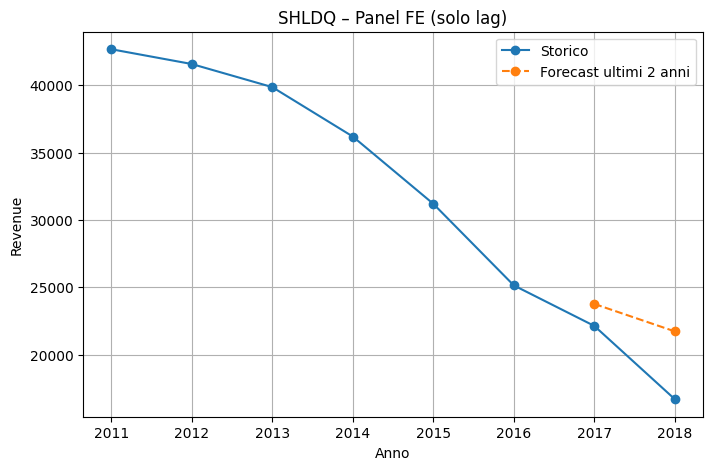


✅ Confronto previsioni vs reali (ultimi 2 anni per azienda):
    Year      Reale       Previsto Company
0   2021  365817.00  337619.695571    AAPL
1   2022  394328.00  420547.194657    AAPL
2   2021   52057.00   46379.182128     AIG
3   2022   56437.00   50650.793082     AIG
4   2021  469822.00  576586.560004    AMZN
5   2022  513983.00  560281.905947    AMZN
6   2021   30169.69   31408.595597     BCS
7   2022   30868.08   29767.045760     BCS
8   2021  257637.00  237241.263609    GOOG
9   2022  282836.00  321238.203777    GOOG
10  2021   79024.00   94515.891015    INTC
11  2022   63054.00   85237.542879    INTC
12  2021   23222.90   21093.001962     MCD
13  2022   23182.60   23141.209953     MCD
14  2022  198270.00  175773.779776    MSFT
15  2023  211915.00  156342.476096    MSFT
16  2022   26914.00   19613.884305    NVDA
17  2023   26974.00   32962.085702    NVDA
18  2021   20642.00   21381.451656     PCG
19  2022   21680.00   20949.448362     PCG

📊 Metriche per azienda:
   Company

In [16]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Previsioni ultimi 2 anni per tutte le aziende
all_forecasts = []
metrics = []

for comp in df_extra["Company"].unique():
    try:
        print(f"\n=== {comp} ===")
        res = panel_forecast(comp, df_extra, use_year_fe=True)  # fa plot + tabella

        # aggiungi colonna Company e salva i risultati
        res = res.assign(Company=comp)
        all_forecasts.append(res)

        # calcola metriche di errore
        y_true = res["Reale"].values
        y_pred = res["Previsto"].values
        y_naive = df_extra.loc[
            (df_extra["Company"] == comp) & (df_extra["Year"].isin(res["Year"])),
            "Revenue_lag1"
        ].values

        metrics.append({
            "Company": comp,
            "MAE_model": mae(y_true, y_pred),
            "MAPE_model": mape(y_true, y_pred),
            "MAE_naive": mae(y_true, y_naive),
            "MAPE_naive": mape(y_true, y_naive)
        })

    except Exception as e:
        print(f"❌ Problema con {comp}: {e}")

# Unisci tutte le previsioni e metriche
df_forecasts = pd.concat(all_forecasts, ignore_index=True)
df_metrics = pd.DataFrame(metrics)

print("\n✅ Confronto previsioni vs reali (ultimi 2 anni per azienda):")
print(df_forecasts.head(20))

print("\n📊 Metriche per azienda:")
print(df_metrics)

# Medie complessive
print("\n📊 Medie complessive su tutte le aziende:")
print("MAE modello   =", df_metrics["MAE_model"].mean())
print("MAPE modello  =", df_metrics["MAPE_model"].mean(), "%")
print("MAE naive     =", df_metrics["MAE_naive"].mean())
print("MAPE naive    =", df_metrics["MAPE_naive"].mean(), "%")
